In [1]:
# import packages and files

import h5py
import numpy as np
from pathlib import Path

import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams.update({
        "axes.linewidth": 2, "xtick.major.width": 2, "ytick.major.width": 2})
import matplotlib.colors as colors

from __future__ import annotations
from pyhipp import plot
from pyhipp.core import DataDict

from pyccb import samples
from pyccb.process.halo_web import HaloWebCross
from pyccb.process import ab_matching
from pyccb.process import calc_zw

SAMPLE_PATH = Path('/Volumes/T7/halo_web')  # Path in local

N_grid = 256
file_halo_sample = SAMPLE_PATH / 'halo_sample.hdf5'
file_tidal_field = SAMPLE_PATH / f'cf_field_sample.hdf5'
dir_output = SAMPLE_PATH / 'output'

with h5py.File(file_tidal_field, 'r', locking=False) as f:
    print(f.keys())

<KeysViewHDF5 ['delta_sm_x', 'l_box', 'lams', 'n_grids']>


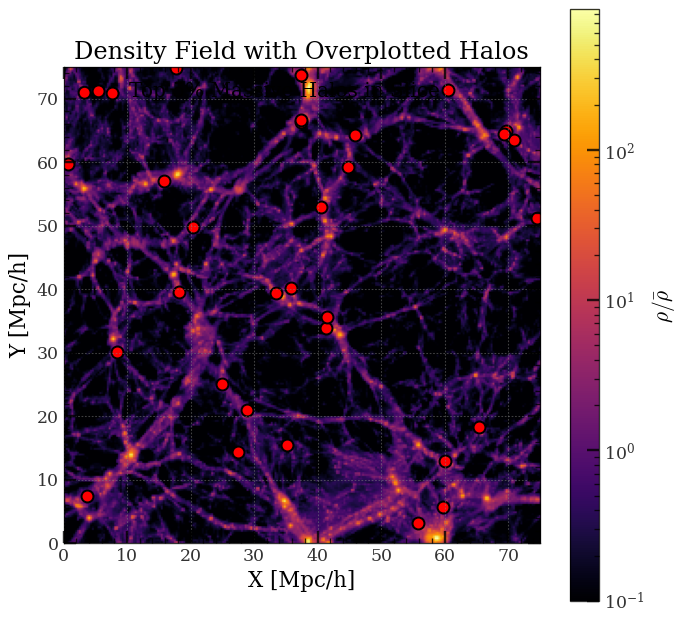

In [2]:
# plot field slice

slice_index = 126  # Choose a slice from the middle of the box (0 to 255)
slice_thickness = 5 # Number of slices to average over for a thicker projection

# --- Load Data ---
field_plot = h5py.File(file_tidal_field, 'r', locking=False)
delta_sm_x = np.array(field_plot['delta_sm_x'])
l_box = np.array(field_plot['l_box'])
n_grids = np.array(field_plot['n_grids'])

# --- Create Projection ---
# Averaging a few slices can make features clearer
slice_data = np.mean(delta_sm_x[:, :, slice_index : slice_index + slice_thickness], axis=2)

# --- Load Halo Data ---
with h5py.File(file_halo_sample, 'r', locking=False) as f:
    halo_pos = f['position'][:]
    halo_mass = f['mass'][:]

# Select massive halos to make the plot cleaner
mass_cut = np.quantile(halo_mass, 0.95) # Plot the most massive 5% of halos
massive_halos_pos = halo_pos[halo_mass > mass_cut]

# --- Select halos within the plotted slice ---
z_min = slice_index * l_box / n_grids
z_max = (slice_index + slice_thickness) * l_box / n_grids
in_slice_mask = (massive_halos_pos[:, 2] >= z_min) & (massive_halos_pos[:, 2] < z_max)
halos_in_slice = massive_halos_pos[in_slice_mask]

# --- Plotting (reusing the plot from Method 1) ---
fig, ax = plt.subplots(figsize=(8, 8))
im = ax.imshow((1 + slice_data).T, origin='lower', extent=[0, l_box, 0, l_box],
               cmap='inferno', norm=colors.LogNorm(vmin=0.1, vmax=(1 + delta_sm_x.max())/10))

# Overplot halo positions
ax.scatter(halos_in_slice[:, 0], halos_in_slice[:, 1], 
           edgecolors='black', s=80, lw=1.5, facecolors='red',
           label=f'Top 5% Massive Halos in Slice')

ax.set_title(f'Density Field with Overplotted Halos')
ax.set_xlabel('X [Mpc/h]')
ax.set_ylabel('Y [Mpc/h]')
ax.legend()
fig.colorbar(im, ax=ax, label=r'$\rho / \bar{\rho}$')
plt.show()

In [5]:
# plot vff vs lambda_th

from tqdm import tqdm

lambda_th_values = np.linspace(-1.0, 1.0, 101)


def calculate_vff_vs_lambda(lams: np.ndarray, lambda_thresholds: np.ndarray) -> dict:
    vff_results = {
        'knot': [],
        'filament': [],
        'sheet': [],
        'void': []
    }
    
    total_cells = np.prod(lams.shape[:-1])

    for i, l_th in tqdm(enumerate(lambda_thresholds)):
        n_above_thresh = (lams > l_th).sum(axis=-1)
        
        vff_knot = np.sum(n_above_thresh == 3) / total_cells
        vff_filament = np.sum(n_above_thresh == 2) / total_cells
        vff_sheet = np.sum(n_above_thresh == 1) / total_cells
        vff_void = np.sum(n_above_thresh == 0) / total_cells
        
        vff_results['knot'].append(vff_knot)
        vff_results['filament'].append(vff_filament)
        vff_results['sheet'].append(vff_sheet)
        vff_results['void'].append(vff_void)

    for key in vff_results:
        vff_results[key] = np.array(vff_results[key])
        
    return vff_results



def plot_vff(lambda_thresholds: np.ndarray, vff_data: dict):
    fig, ax = plt.subplots(figsize=(8, 6))

    ax.plot(lambda_thresholds, vff_data['void'],     color='black', linestyle='-',  lw=2, label='void')
    ax.plot(lambda_thresholds, vff_data['sheet'],    color='black', linestyle='--', lw=2, label='sheet')
    ax.plot(lambda_thresholds, vff_data['filament'], color='black', linestyle=':',  lw=2, label='filament')
    ax.plot(lambda_thresholds, vff_data['knot'],     color='black', linestyle='-.', lw=2, label='knot')

    ax.set_xlabel(r'$\lambda_{th}$', fontsize=16)
    ax.set_ylabel('Volume Filling Fraction', fontsize=16)
    ax.set_title('Cosmic Web Volume Fractions at z=0 (TNG100-1-Dark)', fontsize=18)
    
    ax.set_xlim(-1.0, 1.0)
    ax.set_ylim(0.0, 1.0)
    
    ax.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(fontsize=14)
    
    plt.tight_layout()
    plt.show()

101it [00:11,  8.47it/s]


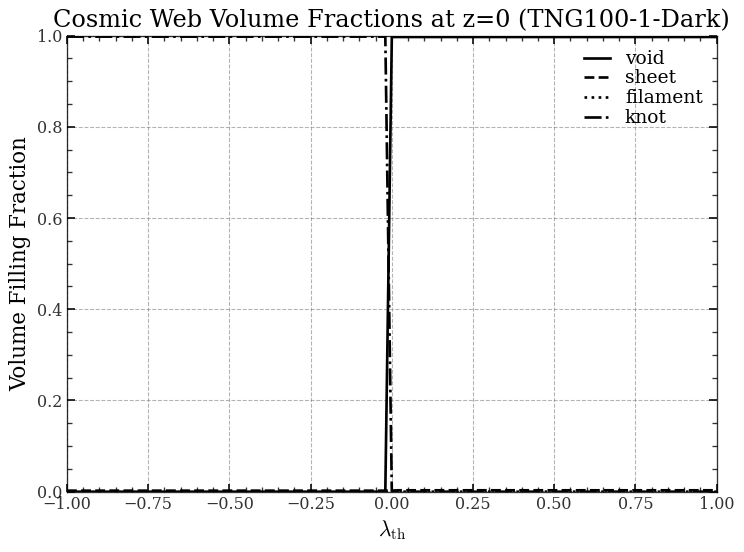

[[[[-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   ...
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]]

  [[-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   ...
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]]

  [[-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   ...
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-38  0.0000000e+00  0.0000000e+00]]

  ...

  [[-6.2803097e-38  0.0000000e+00  0.0000000e+00]
   [-6.2803097e-

In [4]:
with h5py.File(file_tidal_field, 'r', locking=False) as f:
    lams_data = f['lams'][:]

vff_results = calculate_vff_vs_lambda(lams_data, lambda_th_values)
plot_vff(lambda_th_values, vff_results)
print(lams_data[:5])
print(vff_results['knot'])